In [1]:
import numpy as np
import pickle
import os
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# === 1. Load Real Preprocessed Data ===
X_all_normalized = np.load('preprocessed_data/X_all_normalized.npy')
with open('preprocessed_data/sym_all.pkl', 'rb') as f:
    sym_all = pickle.load(f)

In [2]:
# === 2. Map Beat Symbols to Class Indices ===
unique_classes = sorted(set(sym_all))
label_to_index = {label: idx for idx, label in enumerate(unique_classes)}
num_classes = len(unique_classes)

# Create y_all as integer class labels
y_all = np.array([label_to_index[sym] for sym in sym_all])

In [3]:
def load_and_append_synthetic(X_real, y_real, synth_map, label_to_index, base_path=''):
    """
    Load synthetic data and append it to the real dataset.

    Parameters:
        X_real (np.ndarray): Real ECG data.
        y_real (np.ndarray): Real labels (int format).
        synth_map (dict): Dictionary of class_label: filename.
        label_to_index (dict): Mapping from label to integer index.
        base_path (str): Optional base directory for synthetic files.

    Returns:
        X_combined (np.ndarray), y_combined (np.ndarray)
    """
    X_synth_list = []
    y_synth_list = []

    for label, filename in synth_map.items():
        path = os.path.join(base_path, filename)
        if os.path.exists(path):
            print(f"Loading synthetic data for class '{label}' from {filename}")
            X_synth = np.load(path)
            y_synth = np.full((X_synth.shape[0],), label_to_index[label])
            X_synth_list.append(X_synth)
            y_synth_list.append(y_synth)
        else:
            print(f"Warning: File {filename} not found. Skipping class '{label}'.")

    if X_synth_list:
        X_synth_all = np.vstack(X_synth_list)
        y_synth_all = np.concatenate(y_synth_list)
        X_combined = np.vstack([X_real, X_synth_all])
        y_combined = np.concatenate([y_real, y_synth_all])
    else:
        print("No synthetic files were successfully loaded.")
        X_combined, y_combined = X_real, y_real

    return X_combined, y_combined


In [4]:
# === 3. Load the Generated Class Samples ===

# Synthetic file mapping
synthetic_files = {
    # Sample size < 10
    'S': 'generated_S_signals.npy',

    # 10 < Sample size < 8000
    'J': 'generated_JJ_signals.npy',
    'A': 'generated_AA_signals.npy',
    'e': 'generated_e_signals.npy',
    'f': 'generated_f_signals.npy',
    'F': 'generated_FF_signals.npy',
    'j': 'generated_j_signals.npy',
    '/': 'generated_o_signals.npy',
    'R': 'generated_R_signals.npy',
    'V': 'generated_V_signals.npy',
    'E': 'generated_EE_signals.npy',
    'a': 'generated_a_signals.npy',
}


# === 4. Combine Real + Synthetic Data ===
X_combined, y_combined = load_and_append_synthetic(X_all_normalized, y_all, synthetic_files, label_to_index, base_path='generated_data')


Loading synthetic data for class 'S' from generated_S_signals.npy
Loading synthetic data for class 'J' from generated_JJ_signals.npy
Loading synthetic data for class 'A' from generated_AA_signals.npy
Loading synthetic data for class 'e' from generated_e_signals.npy
Loading synthetic data for class 'f' from generated_f_signals.npy
Loading synthetic data for class 'F' from generated_FF_signals.npy
Loading synthetic data for class 'j' from generated_j_signals.npy
Loading synthetic data for class '/' from generated_o_signals.npy
Loading synthetic data for class 'R' from generated_R_signals.npy
Loading synthetic data for class 'V' from generated_V_signals.npy
Loading synthetic data for class 'E' from generated_EE_signals.npy
Loading synthetic data for class 'a' from generated_a_signals.npy


In [5]:
X_combined.shape

(178847, 2160)

In [6]:
# === 5. Shuffle the Dataset ===
X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

In [7]:
# === 6. Reshape for Conv1D (add channel dimension) ===
X_combined = X_combined[..., np.newaxis]  # shape becomes (samples, 1080, 1)

# === 7. One-Hot Encode Labels ===
y_combined_categorical = to_categorical(y_combined, num_classes=num_classes)

In [8]:
# === 8. Split into Train and Validation Sets (optional) ===
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined_categorical, test_size=0.2, random_state=42)

In [9]:
total_samples = X_combined.shape[0]
train_samples = X_train.shape[0]
test_samples = X_val.shape[0]

print(f"Total samples: {total_samples}")
print(f"Training samples: {train_samples} ({train_samples / total_samples:.2%})")
print(f"Testing samples: {test_samples} ({test_samples / total_samples:.2%})")

Total samples: 178847
Training samples: 143077 (80.00%)
Testing samples: 35770 (20.00%)


In [10]:
from collections import Counter
# Decode one-hot encoded labels back to class indices
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Count samples per class
train_class_counts = Counter(y_train_labels)
val_class_counts = Counter(y_val_labels)

# Map indices back to class labels (optional)
index_to_label = {v: k for k, v in label_to_index.items()}

# Print results
print("=== Training Set Class Distribution ===")
for idx, count in sorted(train_class_counts.items()):
    print(f"Class {index_to_label[idx]} (index {idx}): {count} samples")

print("\n=== Validation Set Class Distribution ===")
for idx, count in sorted(val_class_counts.items()):
    print(f"Class {index_to_label[idx]} (index {idx}): {count} samples")

=== Training Set Class Distribution ===
Class / (index 0): 6424 samples
Class A (index 1): 6411 samples
Class E (index 2): 6383 samples
Class F (index 3): 6398 samples
Class J (index 4): 6395 samples
Class L (index 5): 6484 samples
Class N (index 6): 59916 samples
Class R (index 7): 6369 samples
Class S (index 8): 6392 samples
Class V (index 9): 6411 samples
Class a (index 10): 6332 samples
Class e (index 11): 6371 samples
Class f (index 12): 6371 samples
Class j (index 13): 6420 samples

=== Validation Set Class Distribution ===
Class / (index 0): 1576 samples
Class A (index 1): 1589 samples
Class E (index 2): 1617 samples
Class F (index 3): 1602 samples
Class J (index 4): 1605 samples
Class L (index 5): 1568 samples
Class N (index 6): 14879 samples
Class R (index 7): 1631 samples
Class S (index 8): 1608 samples
Class V (index 9): 1589 samples
Class a (index 10): 1668 samples
Class e (index 11): 1629 samples
Class f (index 12): 1629 samples
Class j (index 13): 1580 samples


In [11]:
# === 9. Define Your CNN Model ===
model = Sequential([
    Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-26 20:08:38.609535: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-26 20:08:38.609575: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-26 20:08:38.609587: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-26 20:08:38.609811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-26 20:08:38.609824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fa

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2154, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1077, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1073, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 536, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 534, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 267, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 68352)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,749,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,891,150 (33.92 MB)

 Trainable params: 8,891,150 (33.92 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
import time
# Start timer
start_time = time.time()

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_val, y_val)
)

# End timer
end_time = time.time()

# Total training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

Epoch 1/15


2025-05-26 20:08:42.161327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1118/1118 ━━━━━━━━━━━━━━━━━━━━ 108s 95ms/step - accuracy: 0.6687 - loss: 4.6882 - val_accuracy: 0.8093 - val_loss: 7.3106
Epoch 2/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 104s 93ms/step - accuracy: 0.7098 - loss: 6.5330 - val_accuracy: 0.8093 - val_loss: 2.9298
Epoch 3/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 103s 92ms/step - accuracy: 0.7337 - loss: 3.6962 - val_accuracy: 0.8093 - val_loss: 0.7423
Epoch 4/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 103s 92ms/step - accuracy: 0.8083 - loss: 0.7617 - val_accuracy: 0.8093 - val_loss: 0.7256
Epoch 5/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 104s 93ms/step - accuracy: 0.8079 - loss: 0.7401 - val_accuracy: 0.8093 - val_loss: 0.7219
Epoch 6/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 104s 93ms/step - accuracy: 0.7933 - loss: 3.3260 - val_accuracy: 0.8660 - val_loss: 0.4565
Epoch 7/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 103s 92ms/step - accuracy: 0.8601 - loss: 0.6338 - val_accuracy: 0.9065 - val_loss: 0.4116
Epoch 8/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 104s 93ms/step - accuracy: 0.8632 - lo

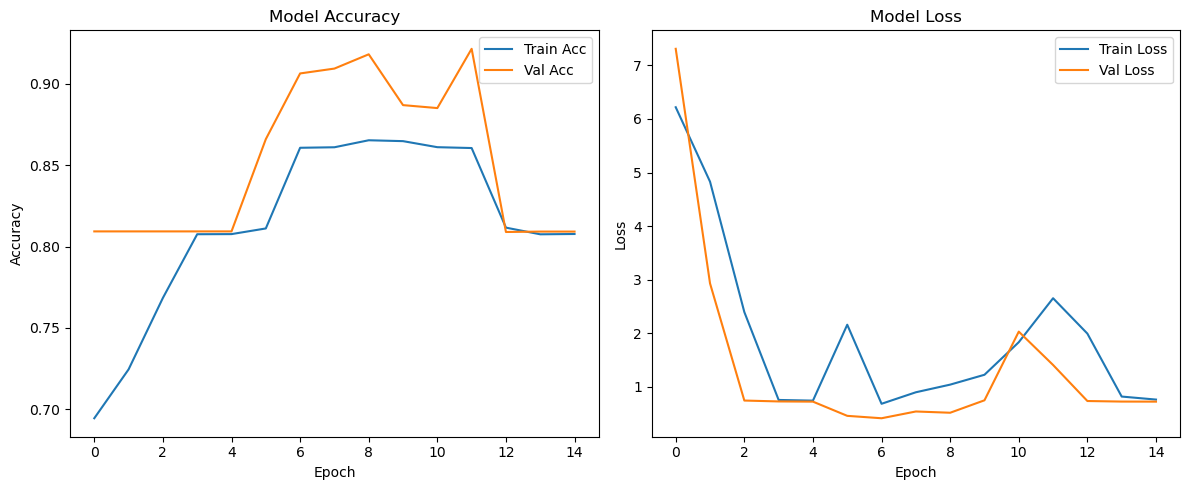

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predictions
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\n📊 Evaluation Metrics:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

1118/1118 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step

📊 Evaluation Metrics:
Accuracy  : 0.8092
Precision : 0.9055
Recall    : 0.6940
F1-score  : 0.7186


/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Detailed Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.1282    0.2272      1576
           1     1.0000    0.6721    0.8039      1589
           2     0.9987    0.9870    0.9928      1617
           3     1.0000    0.9057    0.9505      1602
           4     1.0000    0.9931    0.9966      1605
           5     0.0000    0.0000    0.0000      1568
           6     0.6856    0.9997    0.8134     14879
           7     0.9934    0.0920    0.1684      1631
           8     1.0000    1.0000    1.0000      1608
           9     1.0000    0.1095    0.1974      1589
          10     1.0000    0.9820    0.9909      1668
          11     1.0000    0.9969    0.9985      1629
          12     1.0000    0.8828    0.9377      1629
          13     0.9993    0.9665    0.9826      1580

    accuracy                         0.8092     35770
   macro avg     0.9055    0.6940    0.7186     35770
weighted avg     0.8250    0.8092    0.7554    

/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

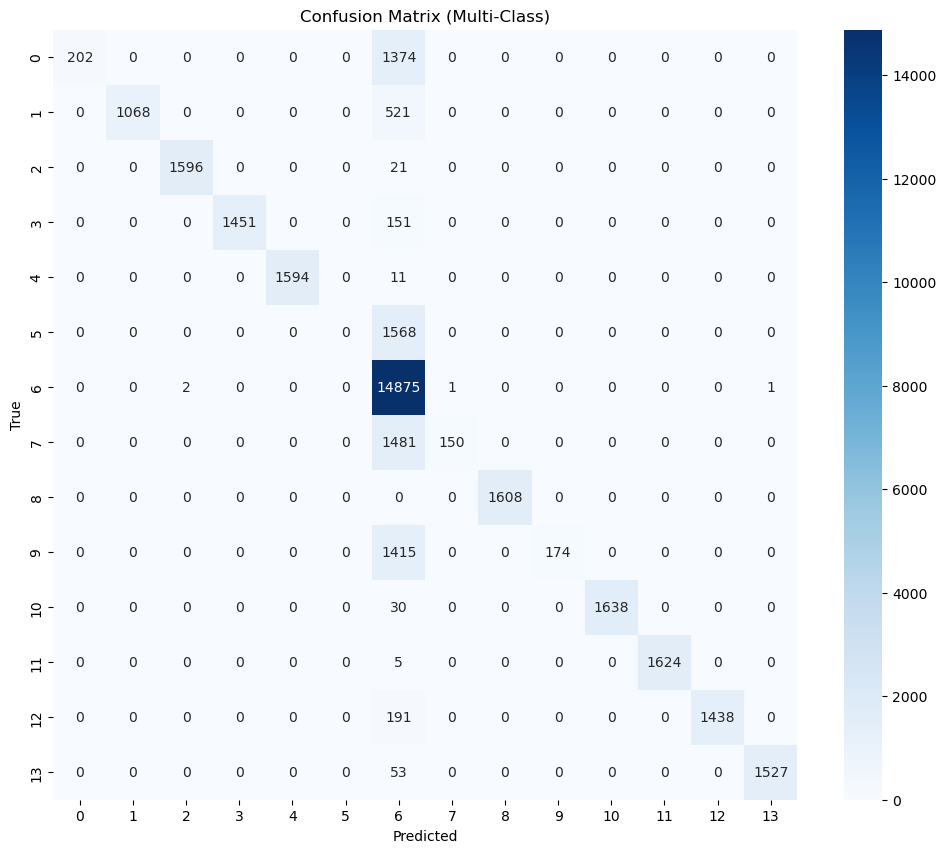

In [16]:
# Optional: Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
class_labels = list(range(14))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Multi-Class)')
plt.show()

/var/folders/vy/h0yt7lx97b5ct5kp84j7dk_40000gn/T/ipykernel_1045/2714331143.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=recall_per_class, palette='viridis')


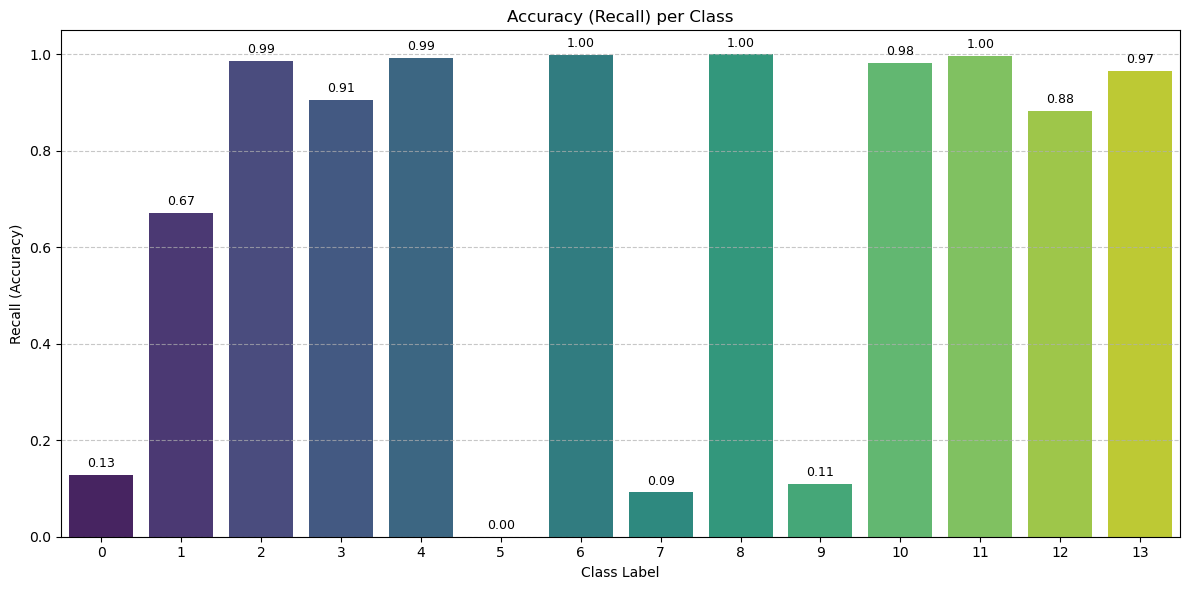

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class labels (0–13)
class_labels = list(range(14))

# Recall values (from your classification report)
recall_per_class = [
    0.1282,0.6721,0.9870,0.9057,0.9931,0.0000,0.9997,0.0920,1.0000,0.1095,0.9820,0.9969,0.8828,0.9665
]

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels, y=recall_per_class, palette='viridis')
plt.title('Accuracy (Recall) per Class')
plt.xlabel('Class Label')
plt.ylabel('Recall (Accuracy)')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display values on bars
for i, rec in enumerate(recall_per_class):
    plt.text(i, rec + 0.01, f"{rec:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


/var/folders/vy/h0yt7lx97b5ct5kp84j7dk_40000gn/T/ipykernel_1045/4224502895.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=recall_per_class, palette='viridis')


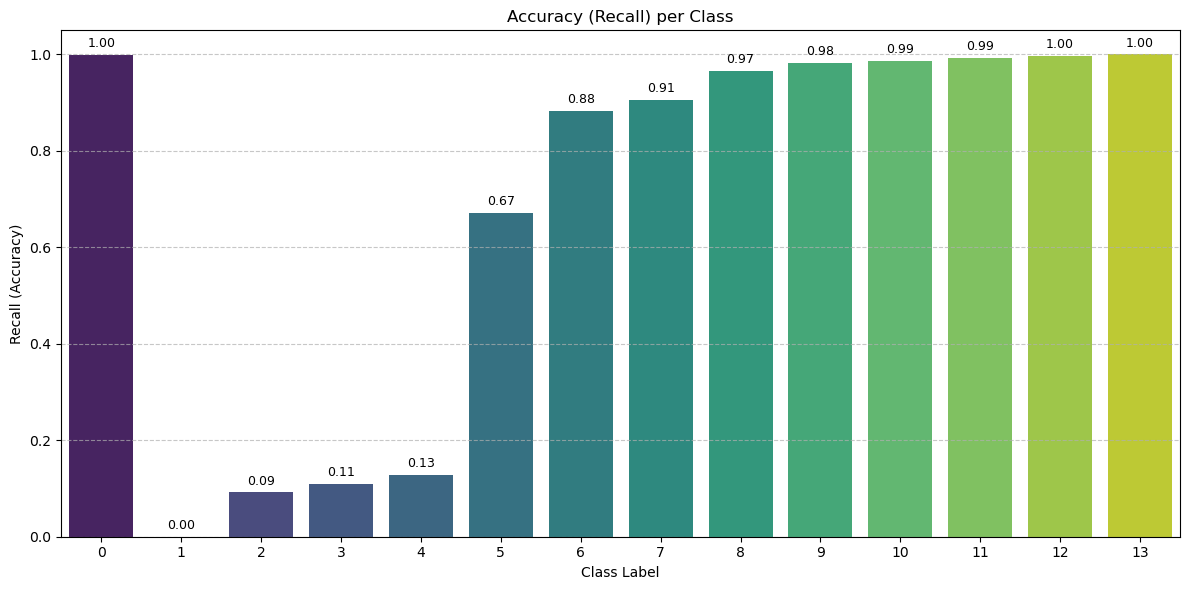

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class labels (0–13)
class_labels = list(range(14))

# Recall values (from your classification report)
recall_per_class = [
    0.9997,0.0000,0.0920,0.1095,0.1282,0.6721,0.8828,0.9057,0.9665,0.9820,0.9870,0.9931,0.9969,1.0000
]

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels, y=recall_per_class, palette='viridis')
plt.title('Accuracy (Recall) per Class')
plt.xlabel('Class Label')
plt.ylabel('Recall (Accuracy)')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display values on bars
for i, rec in enumerate(recall_per_class):
    plt.text(i, rec + 0.01, f"{rec:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
